In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
from sklearn import svm

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pymaster as nmt
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

## Load in data

### SDSS

In [3]:
fn_sdss_full = '../data/SDSS_DR16Q_v4.fits'
tab_sdss_full = Table.read(fn_sdss_full, format='fits')

In [4]:
g_sdss = tab_sdss_full['GAIA_G_MAG']
w1_sdss = tab_sdss_full['W1_MAG']
w2_sdss = tab_sdss_full['W2_MAG']

In [5]:
idx_nog = (np.abs(1+g_sdss)<1e-6) | np.isnan(g_sdss)
idx_nowise = (np.abs(1+w1_sdss)<1e-6) | (np.abs(1+w2_sdss)<1e-6) | np.isnan(w1_sdss) | np.isnan(w2_sdss)
print(np.sum(idx_nog))
print(np.sum(~idx_nog))
print(np.sum(idx_nowise))

print(np.sum(~idx_nog & (g_sdss<20.4)))

280640
469774
1034
276404


In [6]:
idx_hasphot = ~idx_nog & ~idx_nowise
print(np.sum(idx_hasphot))

467785


In [7]:
g_w1_sdss = (g_sdss-w1_sdss)[idx_hasphot]
w1_w2_sdss = (w1_sdss-w2_sdss)[idx_hasphot]

In [8]:
X = np.array((g_w1_sdss, w1_w2_sdss)).T
print(X.shape)

(467785, 2)


In [9]:
rng = default_rng(seed=42)
X_sub = rng.choice(X, size=int(len(X)/10), axis=0)
print(X_sub.shape)

(46778, 2)


### Gaia

In [10]:
fn_gaia_all = '../data/gaia_slim_xsdss.fits'
tab_gaia_all = utils.load_table(fn_gaia_all)
N_data_all = len(tab_gaia_all)
print(f"Number of data sources: {N_data_all}")

Number of data sources: 6649162


In [11]:
idx_fg_gaia = np.isfinite(tab_gaia_all['phot_g_mean_mag'])
print(np.sum(idx_fg_gaia))
idx_fw1_gaia = np.isfinite(tab_gaia_all['w1mpro'])
print(np.sum(idx_fw1_gaia))
idx_fw2_gaia = np.isfinite(tab_gaia_all['w2mpro'])
print(np.sum(idx_fw2_gaia))
idx_hasphot_gaia = idx_fg_gaia & idx_fw1_gaia & idx_fw2_gaia
print(np.sum(idx_hasphot_gaia))

6597754
1721668
1721669
1717492


In [12]:
X_gaia = np.array((tab_gaia_all['g_w1'], tab_gaia_all['w1_w2'])).T[idx_hasphot_gaia]

In [13]:
X_gaia_sub = rng.choice(X, size=int(len(X_gaia)/10), axis=0)
print(X_gaia_sub.shape)

(171749, 2)


## SVM

In [22]:
clf = svm.OneClassSVM(nu=0.02, kernel="rbf", gamma='scale')
#clf = svm.OneClassSVM(nu=0.5, kernel="poly", gamma='auto')
clf.fit(X_sub)

OneClassSVM(nu=0.02)

In [23]:
y_gaia_sub = clf.predict(X_gaia)

In [24]:
idx_inclass = y_gaia_sub==1
c_gaia = np.array(['grey']*len(X_gaia))
print(c_gaia)
c_gaia[idx_inclass] = 'k'

['grey' 'grey' 'grey' ... 'grey' 'grey' 'grey']


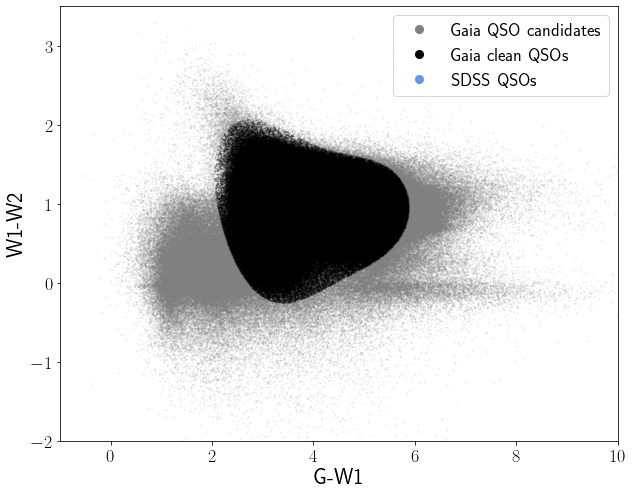

In [25]:
plt.figure(figsize=(10,8))

colors = ['grey', 'black', 'cornflowerblue']
labels = ['Gaia QSO candidates', 'Gaia clean QSOs', 'SDSS QSOs']
plt.scatter(*X_gaia.T, 
            c=c_gaia, s=1, alpha=0.1, label=labels[0])
# plt.scatter(*X.T, 
#             c='orange', s=1, alpha=0.1, label=labels[2])

# plot cuts
ax = plt.gca()

xlim = (-1,10)
ylim = (-2, 3.5)
plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel('G-W1')
plt.ylabel('W1-W2')

legend_elements_markers = [Line2D([0], [0], marker='o', color=colors[i], label=labels[i],
                          markersize=8, ls='None') for i in range(len(colors))]

plt.legend(handles=legend_elements_markers, loc='upper right')

# local outlier factor

In [56]:
from sklearn.neighbors import LocalOutlierFactor

In [125]:
lof = LocalOutlierFactor(n_neighbors=200, contamination=0.1, novelty=True)
lof.fit(X)

LocalOutlierFactor(contamination=0.1, n_neighbors=200, novelty=True)

In [126]:
y_gaia_sub = lof.predict(X_gaia)

In [127]:
idx_inclass = y_gaia_sub==1
c_gaia = np.array(['orange']*len(X_gaia))
print(c_gaia)
c_gaia[idx_inclass] = 'k'

['orange' 'orange' 'orange' ... 'orange' 'orange' 'orange']


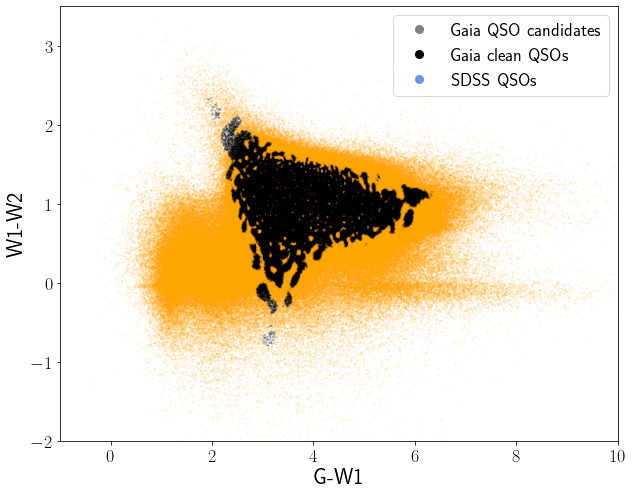

In [128]:
plt.figure(figsize=(10,8))

colors = ['grey', 'black', 'cornflowerblue']
labels = ['Gaia QSO candidates', 'Gaia clean QSOs', 'SDSS QSOs']
plt.scatter(*X_gaia.T, 
            c=c_gaia, s=1, alpha=0.1, label=labels[0])
# plt.scatter(*X.T, 
#             c='orange', s=1, alpha=0.1, label=labels[2])

# plot cuts
ax = plt.gca()

#y_eq = (cut_0[2]*cut_1[0] - cut_1[2]*cut_0[0])/(cut_0[1]*cut_1[0] - cut_1[1]*cut_0[0])
#x_eq = (cut_0[2]*cut_1[1] - cut_1[2]*cut_0[1])/(cut_0[0]*cut_1[1] - cut_1[0]*cut_0[1])
#print(x_eq)

xlim = (-1,10)
ylim = (-2, 3.5)
plt.xlim(xlim)
plt.ylim(ylim)

# plot_cut(ax, cut_0, x_eq=x_eq, only_plot='above')
# plot_cut(ax, cut_1, x_eq=x_eq, only_plot='below')

# plt.xlim(xlim)
# plt.ylim(ylim)

plt.xlabel('G-W1')
plt.ylabel('W1-W2')

legend_elements_markers = [Line2D([0], [0], marker='o', color=colors[i], label=labels[i],
                          markersize=8, ls='None') for i in range(len(colors))]

plt.legend(handles=legend_elements_markers, loc='upper right')

# isolation forest

In [116]:
from sklearn.ensemble import IsolationForest

In [129]:
clf = IsolationForest(random_state=0, contamination=0.1)
clf.fit(X)

IsolationForest(contamination=0.1, random_state=0)

In [130]:
y_gaia_sub = clf.predict(X_gaia)

In [131]:
idx_inclass = y_gaia_sub==1
c_gaia = np.array(['orange']*len(X_gaia))
print(c_gaia)
c_gaia[idx_inclass] = 'k'

['orange' 'orange' 'orange' ... 'orange' 'orange' 'orange']


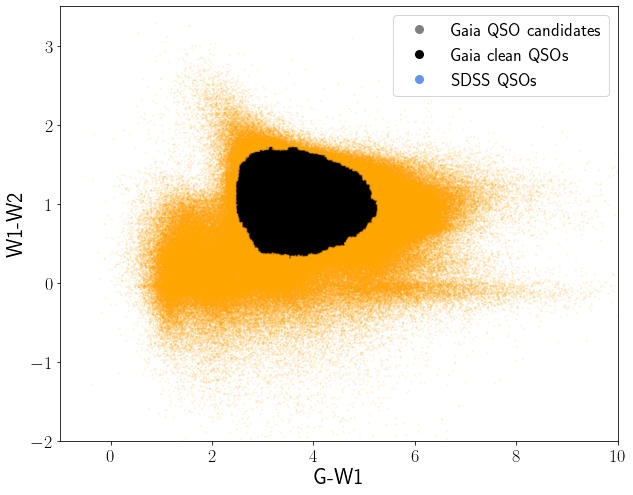

In [132]:
plt.figure(figsize=(10,8))

colors = ['grey', 'black', 'cornflowerblue']
labels = ['Gaia QSO candidates', 'Gaia clean QSOs', 'SDSS QSOs']
plt.scatter(*X_gaia.T, 
            c=c_gaia, s=1, alpha=0.1, label=labels[0])
# plt.scatter(*X.T, 
#             c='orange', s=1, alpha=0.1, label=labels[2])

# plot cuts
ax = plt.gca()

#y_eq = (cut_0[2]*cut_1[0] - cut_1[2]*cut_0[0])/(cut_0[1]*cut_1[0] - cut_1[1]*cut_0[0])
#x_eq = (cut_0[2]*cut_1[1] - cut_1[2]*cut_0[1])/(cut_0[0]*cut_1[1] - cut_1[0]*cut_0[1])
#print(x_eq)

xlim = (-1,10)
ylim = (-2, 3.5)
plt.xlim(xlim)
plt.ylim(ylim)

# plot_cut(ax, cut_0, x_eq=x_eq, only_plot='above')
# plot_cut(ax, cut_1, x_eq=x_eq, only_plot='below')

# plt.xlim(xlim)
# plt.ylim(ylim)

plt.xlabel('G-W1')
plt.ylabel('W1-W2')

legend_elements_markers = [Line2D([0], [0], marker='o', color=colors[i], label=labels[i],
                          markersize=8, ls='None') for i in range(len(colors))]

plt.legend(handles=legend_elements_markers, loc='upper right')

# Novelty detector + cuts

In [26]:
# cut: (a, b, c) where ax+by=c
def plot_cut(ax, cut, x_eq=None, only_plot=None):

    xx = np.array(ax.get_xlim())
    yy = np.array(ax.get_ylim())
    
    if only_plot=='above':
        xx[0] = x_eq
    if only_plot=='below':
        xx[1] = x_eq

    idx_plot = np.arange(len(xx))
    if abs(cut[0]) > abs(cut[1]):
        # solve ax+by=c for x: (c-by)/a
        xcut = (cut[2] - cut[1]*yy)/cut[0]
        ax.plot(xcut, yy, 'k-', lw=0.7)
    else:
        # solve ax+by=c for y: (c-ax)/b
        ycut = (cut[2] - cut[0]*xx)/cut[1]
        ax.plot(xx, ycut, 'k-', lw=0.7)
        

def cut_index(g_w1, w1_w2, cut):
    return cut[0] * g_w1 + cut[1] * w1_w2 > cut[2]

In [27]:
# TODO: better cuts! 
cut_0 = 0., 1., 0.35
cut_1 = 1., 1., 3.5#2.9

In [28]:
color_cuts = [cut_0, cut_1]
idx_clean_gaia = utils.gw1_w1w2_cuts_index(tab_gaia_all[idx_hasphot_gaia], color_cuts)
print(np.sum(idx_clean_gaia))

Fraction that make cuts: 0.898
1541582


In [29]:
idx_inclass = (y_gaia_sub==1) | idx_clean_gaia
c_gaia = np.array(['grey']*len(X_gaia))
print(c_gaia)
c_gaia[idx_inclass] = 'k'

['grey' 'grey' 'grey' ... 'grey' 'grey' 'grey']


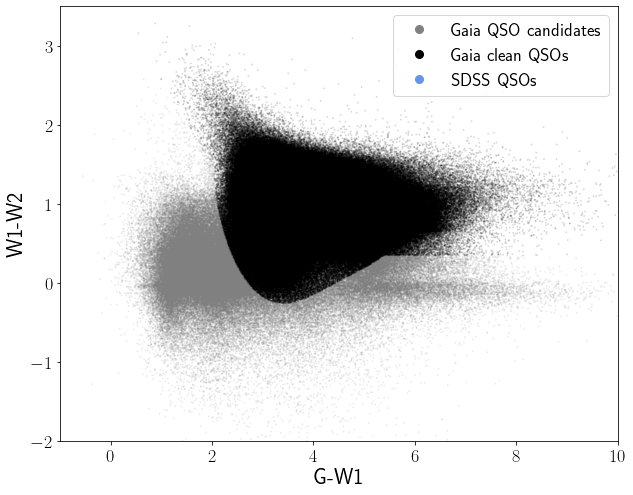

In [30]:
plt.figure(figsize=(10,8))

colors = ['grey', 'black', 'cornflowerblue']
labels = ['Gaia QSO candidates', 'Gaia clean QSOs', 'SDSS QSOs']
plt.scatter(*X_gaia.T, 
            c=c_gaia, s=1, alpha=0.1, label=labels[0])
# plt.scatter(*X.T, 
#             c='orange', s=1, alpha=0.1, label=labels[2])

# plot cuts
ax = plt.gca()

xlim = (-1,10)
ylim = (-2, 3.5)
plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel('G-W1')
plt.ylabel('W1-W2')

legend_elements_markers = [Line2D([0], [0], marker='o', color=colors[i], label=labels[i],
                          markersize=8, ls='None') for i in range(len(colors))]

plt.legend(handles=legend_elements_markers, loc='upper right')